Support algs imported!
1.0926213264465332


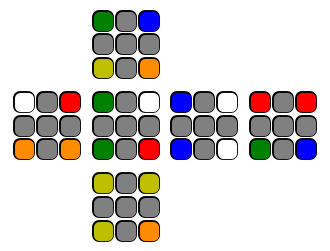

Cube initiated


In [6]:
%run ../cube/Cube.ipynb

import numpy as np
import random
import time
from numba import njit

In [7]:
move_list = np.array(['R', 'R2', 'R\'', 'L', 'L2', 'L\'', 'r', 'r2', 'r\'', 'l', 'l2', 'l\'', 'M', 'M2', 'M\'', 'U', 'U2', 'U\'', 'D', 'D2', 'D\'', 'u', 'u2', 'u\'', 'd', 'd2', 'd\'', 'E', 'E2', 'E\'', 'F', 'F2', 'F\'', 'B', 'B2', 'B\'', 'f', 'f2', 'f\'', 'b', 'b2', 'b\'', 'S', 'S2', 'S\''])
move_to_id = {move: i for i, move in enumerate(move_list)}
id_to_move = {i: move for i, move in enumerate(move_list)}

@njit
def array_to_alg(array):
    # no -1s as moves
    return " ".join([move_list[id] for id in array if id != -1])

# @njit
def alg_to_array(alg):
    return np.array([move_to_id[move] for move in alg.split()])

# function to invert an alg
@njit
def invert_alg_array(alg_array):
    inv_array = alg_array[::-1]
    inv_array = np.concatenate((inv_array[inv_array!=-1], 3*inv_array[inv_array==-1]))
    return inv_array + 2*(1-inv_array%3)

# run once to compile
invert_alg_array(np.array([0, -1, -1, -1]))
array_to_alg(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11, 12, 13, 14, 15, 16, 17,32]))
alg_to_array("R U R' U' R' U' F R f' R' U R S")

array([ 0, 15,  2, 17,  2, 17, 30,  0, 38,  2, 15,  0, 42])

In [8]:
@njit
def cancel_alg_array(alg_array): 
    # cancels an alg array
    changes = True
    pointer = -1
    while changes:
        changes = False
        alg_array = np.concatenate((alg_array[alg_array != -1], alg_array[alg_array == -1]))

        for i in range(len(alg_array)-1):
            if alg_array[i] == -1:
                pointer = i
                break # we can stop here because we know that the rest of the array is -1
            if alg_array[i] == -2:
                alg_array[i] = -1 # we don't need to track this change because it is not a move
                changes = True
                continue
            if alg_array[i]//3 == alg_array[i+1]//3:
                # if it cancels fully, the new move is -2 (which we need to change to -1 later)
                # if it cancels partially, the current move is set to -1 and the next move is changed to the new move

                base_move = alg_array[i]//3*3
                total_rotation = (2 + alg_array[i]%3 + alg_array[i+1]%3)%4-1
                alg_array[i] = -1
                if total_rotation >= 0:
                    alg_array[i+1] = base_move + total_rotation
                else:
                    alg_array[i+1] = -2
                changes = True
        if alg_array[-1] == -2:
            alg_array[-1] = -1

    return alg_array[:pointer]

@njit
def cancel_alg_arrays(alg_array1, alg_array2):
    alg_array = np.concatenate((alg_array1, alg_array2, np.array([-1])))
    return cancel_alg_array(alg_array)

alg1, alg2 = np.array([ 2,8,14]), np.array([6, 2, 3])
cancel_alg_arrays(alg1, alg2)

array([ 2,  8, 14,  6,  2,  3], dtype=int64)

In [18]:
move_transition = np.array([ 
#   [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44],
    [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
	# Start (homegrip)
#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
    [ 3, 0, 5, 0, 0, 0,30, 0,32, 0, 0, 0, 0, 0,36, 8,14,11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,17, 0,20, 0, 0, 0,33, 0,34, 0, 0, 0,35, 0,35], # 1. <> - no pre-auf/adf, can be added for other things
	# After R
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8,14,11,23, 0,26, 0, 0, 0, 0, 0, 0, 0, 0, 0,17, 0,20, 0, 0, 0,33, 0,34, 0, 0, 0,35, 0,35], # 2. <>
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,15,12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 3. <R>
	# After R'
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8,14,11,23, 0,26, 0, 0, 0, 0, 0, 0, 0, 0, 0,17, 0,20, 0, 0, 0,33, 0,34, 0, 0, 0,35, 0,35], # 4. <>
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,10,16,13,25, 0,28, 0, 0, 0, 0, 0, 0, 0, 0, 0,19, 0,22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 5. <R'>
	# After R2
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,15,12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 6. <R> - copy of 3
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,10,16,13,25, 0,28, 0, 0, 0, 0, 0, 0, 0, 0, 0,19, 0,22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 7. <R'> - copy of 5
	# After U
	[ 3, 0, 5, 0, 0, 0, 0, 0,32, 0, 0, 0,36, 0,36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,17, 0,20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,35], # 8. <>
	[ 0, 7, 4, 0, 0, 0, 0, 0,31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 9. <R>
	[ 2, 6, 0, 0, 0, 0,29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #10. <R'> - not used?
	# After U'
	[ 3, 0, 5, 0, 0, 0,30, 0,32, 0, 0, 0,36, 0,36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,17, 0,20, 0, 0, 0, 0, 0, 0, 0, 0, 0,35, 0, 0], #11. <>
	[ 0, 7, 4, 0, 0, 0, 0, 0,31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #12. <R>
	[ 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #13. <R'>
	# After U2
	[ 3, 0, 5, 0, 0, 0,30, 0, 0, 0, 0, 0,36, 0,36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,17, 0,20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #14. <>
	[ 0, 7, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #15. <R>
	[ 2, 6, 0, 0, 0, 0,29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #16. <R'>
#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
	# After F
	[ 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0,11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #17. <> - add U?
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #18. <R> - not used?
	[ 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,16,13,25, 0,28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #19. <R'>
	# After F'
	[ 3, 0, 5, 0, 0, 0,30, 0,32, 0, 0, 0, 0, 0, 0, 8, 0,11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #20. <> - add U'?
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #21. <R> - not used?
	[ 2, 6, 0, 0, 0, 0,29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #22. <R'>
	# After D
	[ 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #23. <>
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #24. <R>
	[ 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #25. <R'>
	# After D'
	[ 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #26. <>
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #27. <R>
	[ 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,19, 0,22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #28. <R'>
#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
	# After r
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8,14,11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #29. <>
	[ 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,15,12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #30. <R>
	# After r'
	[ 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8,14,11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #31. <>
	[ 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,16,13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #32. <R'>
	# After f
	[ 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #33. <>
	# After f'
	[ 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #34. <>
	# After S/S'
	[ 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #35. <>
	# After M/M'
	[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0,11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #36. <>

#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
])

move_transition = np.array([ 
#   [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44],
    [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
	# Start (homegrip)
#   [ R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
    [ 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [ 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])

In [19]:
@njit
def is_regripless(move_array, start_grips = np.array([1, 2, 3]), move_transition = move_transition):
    # check if the alg is regripless
    grips = start_grips
    for move in move_array:
        grips = move_transition[grips, move]
        # print(grips, move, move_list[move])
        if np.all(grips == 0):
            return False
    return True

alg_array = alg_to_array("R U' R2 D' r U2 r' D R2 U R'")
start_grips = np.array([1])
is_regripless(alg_array, start_grips)

False

In [20]:
# same as above, but for a list of grips
@njit
def get_valid_moves_list(grips, last_move, move_transition = move_transition):
    possible_moves = np.zeros(45, dtype=np.int64)
    for grip in grips:
        possible_moves += move_transition[grip]
    viable_moves = np.where(possible_moves)[0]

    return viable_moves[viable_moves//3 != last_move//3]

@njit
def check_rlr(alg_array):
    # ex: R, L, l, r, M
    # max 2 moves from these in a row, and only in one direction (R L is fine, L R is not)
    # we check this in two steps: first we check if there are more than 2 moves from the same grip in a row

    if len(alg_array) < 2:
        return True
    
    for i in range(len(alg_array)-2):
        if alg_array[i]//15 == alg_array[i+1]//15 == alg_array[i+2]//15:
            return False
    
    for i in range(len(alg_array)-1):
        if alg_array[i]//15 == alg_array[i+1]//15 and (alg_array[i]<alg_array[i+1] or alg_array[i]%15>11 or alg_array[i+1]%15>11): # if same axis, force 1, and also make sure none of the moves are slice moves as they are covered by wide moves
            return False
        # # check for "slice moves" resulted by R r' or something similar.
        # if alg_array[i]//15 == alg_array[i+1]//15 and (alg_array[i]%15 - alg_array[i+1]%15):
        #     return False
    return True

@njit
def check_rlr2(alg_array):
    # same as above, but assumes the array has length 3, so we don't need to check that nor loop
    if alg_array[0]//15 == alg_array[1]//15 == alg_array[2]//15:
        return False

    if alg_array[1]//15 == alg_array[2]//15 and (alg_array[1]<alg_array[2] or alg_array[2]%15>11): # if same axis, force 1, and also make sure last move is not slice move as that is covered by wide moves. No need to check second last move is that is checked before in the function above
        return False
    return True

In [ ]:
@njit
def gen_algs(length, start_grips = np.array([1]), move_transition = move_transition):

    algs = np.zeros((1000000, length), dtype = np.int8) # starts with 1 000 000 algs, but will be expanded if needed later on
    i = 0 # keep track of the number of algs we have

    current_grip = np.zeros((length+1, len(start_grips)), dtype = np.int8) # first grip is the start grip
    current_grip[0] = start_grips # this will stay unchanged
    current_alg = -np.ones(length+1, dtype = np.int8)
    current_alg[0] = -1 # not a possible move, so we can start at 0

    pointer = 1 # start pointing at the first move (we use this for both algs and grips)

    while pointer > 0:
        if i == len(algs):
            algs = np.concatenate((algs, np.zeros((1000000, length), dtype = np.int8)))
        # criterion for adding algs: pointer == length
        if pointer == length:
            # if the alg has rlr without the first move, we don't need to check all the other moves
            if check_rlr(current_alg[1:-1]):
                # loop though and add the alg to the array if the last move doesn't regrip
                valid_moves = get_valid_moves_list(current_grip[pointer-1], current_alg[pointer-1], move_transition)
                for move in valid_moves:
                    current_alg[pointer] = move
                    if check_rlr2(current_alg[-3:]): # check if the last two moves are rlr
                        algs[i] = current_alg[1:]
                        i += 1
                    if i == len(algs):
                        algs = np.concatenate((algs, np.zeros((1000000, length), dtype = np.int8)))
                        
            # then we go back one step (instead of setting current_alg[pointer] to 45 and dealing with it next cycle)
            current_alg[pointer] = -1
            pointer -= 1
            continue

        # if we haven't gone back, we increment the current move, set the next grip, and increment the pointer
        current_alg[pointer] += 1
        # make sure the move is valid: 1) it's a valid move, 2) it's not on the same face as the previous move, and 3) it's a regripless move
        while True: #current_alg[pointer] < 45 and current_alg[pointer]//3 == current_alg[pointer-1]//3 and move_transition[current_grip[pointer-1], current_alg[pointer]] != 0:
            if current_alg[pointer] == 45:
                break
            if current_alg[pointer]//3 != current_alg[pointer-1]//3 and (move_transition[current_grip[pointer-1], current_alg[pointer]]).any() != 0:
                break
            current_alg[pointer] += 1
        # criterion for going back: current_alg[pointer] == 45
        if current_alg[pointer] == 45:
            current_alg[pointer] = -1
            pointer -= 1
            continue
        
        # update the grip
        for j in range(len(start_grips)):
            current_grip[pointer, j] = move_transition[current_grip[pointer-1, j], current_alg[pointer]]
        pointer += 1
    
    return algs[:i]

2243862

In [ ]:
def gen_algs_cumulative(max_length, start_grips = [1], min_length = 1, move_transition = move_transition, prnt = True):
    # generates algs of length min_length to max_length
    algs = []
    algs.append(np.array([[-1]*max_length]))
    t = time.time()
    if prnt:
        print(f"Genning search algs...")

    for i in range(min_length, max_length+1):
        new_algs = gen_algs(i, start_grips, move_transition = move_transition)
        # pad with max_length - i -1s
        new_algs = np.pad(new_algs, ((0,0),(0,max_length-i)), constant_values = -1)
        algs.append(new_algs)
        if prnt:
            print(f"Algs of length {i} genned. Time spent: {time.time()-t:.2f}s...")
    if prnt:
        print(f"Done genning algs. Making into np array. Time spent: {time.time()-t:.2f}s")
    algs = np.concatenate(algs)
    return algs

In [32]:
@njit
def U_last_move(alg):
    # we check the last valid move. There might be -1s at the end of the alg so we need to check the last valid move
    for i in range(len(alg)-1, -1, -1):
        if alg[i] != -1:
            return alg[i]//3 == 5 # //3 gives U
    return True # if there are no valid moves, we return True

def gen_table(search_algs, mode, skip_U = True, prnt = True, single_alg = False): # maybe take in cubestate as well?
    # single_alg: if True, we only generate alg per state, if False, we generate a list of algs per state
    # make sure the algs are sorted before adding them to the table so we only add the shortest one
    table = {}
    t = time.time()
    if prnt:
        print(f"Genning table based on {len(search_algs)} algs...")
    cube = Cube(mode)
    cubestate = cube.state 
    k = 0
    for i, alg in enumerate(search_algs):
        if prnt and i and i%(len(search_algs)//10) == 0:
            print(f"{i} ({i/len(search_algs)*100:.2f}%) algs added in {time.time()-t:.2f} seconds...")
        # check that we don't have the trivial alg:
        if np.all(alg == -1):
            continue
        # check that we don't end with U*
        if skip_U and U_last_move(alg):
            continue
        k += 1
        cubestate = _apply_int_moves(cubestate, invert_alg_array(alg))
        ID = id_from_state(cubestate)
        if single_alg:
            if ID not in table:
                table[ID] = alg # we only add one alg per state, make sure it's the shortest one by sorting the algs before
        else:
            if ID not in table:
                table[ID] = [alg]
            else:
                table[ID].append(alg)
        cubestate = _apply_int_moves(cubestate, alg)
    
    if prnt:
        print(f"Table generated in {time.time()-t:.2f} seconds. Size: {len(table)} consisting of {k} algs")
    return table

In [33]:
def meet_in_the_middle(search_algs, table, mode, skip_U = True, prnt = True): # maybe take in cubestate as well?
    # we won't bother creating a Cube object, we will just use the cubestate array
    full_algs = []
    t = time.time()
    if prnt:
        print(f"Genning full algs based on {len(search_algs)} search algs and table of size {len(table)}...")

    cube = Cube(mode)
    cubestate = cube.state 
    for i, setup in enumerate(search_algs):

        if i and i%(len(search_algs)//10) == 0:
            # make it unique
            full_algs = list(set(tuple(map(tuple, full_algs))))
            if prnt:
                print(f"{i} ({i/len(search_algs)*100:.2f}%) setups checked in {time.time()-t:.2f} seconds. {len(full_algs)} full algs found")

        cubestate = _apply_int_moves(cubestate, setup)
        ID = id_from_state(cubestate)

        if ID in table:
            for finish in table[ID]:
                alg = cancel_alg_arrays(setup, finish)

                if len(alg) == 0:
                    continue

                if skip_U and alg[0]//3 == 5:
                    continue

                if len(alg) == 0:
                    continue

                if skip_U and alg[-1]//3 == 5: # in case some moves cancel and we end up with U as the last move. Don't need the function because the last move is always valid when we get here
                    continue

                if check_rlr(alg):
                    full_algs.append(alg)

        cubestate = _apply_int_moves(cubestate, invert_alg_array(setup))

    full_algs = list(set(tuple(map(tuple, full_algs))))
    if prnt:
        print(f"Full algs generated in {time.time()-t:.2f} seconds. {len(full_algs)} algs found")
    return full_algs

In [34]:
# sort each list by length so the shortest algs come first, but keep in mind the AUF should not be counted
@njit
def alg_length(alg):
    return alg.count(" ") + 1 - alg.count("(")

def categorize_full_algs(full_algs, mode=0, skip_U = True, prnt = True):
    # we make a dictionary which will contain every possibility
    # we also make the algs into strings so we can store them in a readable way

    t = time.time()
    if prnt:
        print("Categorizing algs...")

    categorized_algs = {}
    cube = Cube(mode)
    ID = id_from_state(cube.state)
    # we initialize the dictionary with the solved state
    Us = [""] # if we don't skip U, then any AUF is possible
    if skip_U:
        Us = ["","U","U2","U'"] # if we skip U, then all states which are an AUF away will be classified the same
    categorized_algs[ID] = ["()"]
    for i, alg in enumerate(full_algs):
        if prnt and i and i%(len(full_algs)//10) == 0:
            print(f"{i} ({i/len(full_algs)*100:.2f}%) algs added in {time.time()-t:.2f} seconds. {len(categorized_algs)} keys made...")

        # remake the last part to include pre U and post U
        string_alg = array_to_alg(alg)
        added = False
        for auf in Us:
            cube.apply_moves(inverse_alg(auf))
            cube.apply_moves(inverse_alg(string_alg))
            for pre_auf in Us:
                cube.apply_moves(inverse_alg(pre_auf))
                ID = id_from_state(cube.state)
                if ID in categorized_algs:
                    if pre_auf:
                        categorized_algs[ID].append(f"({inverse_alg(pre_auf)}) {string_alg}")
                    else:
                        categorized_algs[ID].append(f"{string_alg}")
                    added = True
                    cube.apply_moves(pre_auf)
                    break
                cube.apply_moves(pre_auf)

            cube.apply_moves(string_alg)
            cube.apply_moves(auf)
            if added:
                break

        
        if not added:
            cube.apply_moves(inverse_alg(string_alg))
            # make a new entry in the dictionary
            ID = id_from_state(cube.state) # get the ID without any U moves
            categorized_algs[ID] = [string_alg]
            cube.apply_moves(string_alg)

    if prnt:
        print(f"Done in {time.time()-t:.2f} seconds.")
        print("Sorting algs by length...")
    for key in categorized_algs:
        categorized_algs[key].sort(key = alg_length)
    if prnt:
        print(f"Done in {time.time()-t:.2f} seconds.")
        print(f"Total of {len(categorized_algs)} keys made.")
    
    return categorized_algs

In [ ]:
def gen_full_algs(length, mode, move_transition = move_transition, start_grips = np.array([1]), skip_U = True, prnt = True, categorize = True, categorize_mode=-1, return_full_alg_list = False, remove_regrips = False): # put everything together
    if categorize and categorize_mode == -1:
        print("Please specify a categorization mode.")
        return

    # length: length of final algs
    # mode: cube mode (0 = all pieces, 2 = LL removed, ...)
    print(f"--- Initiating alg genning up to length {length} ---")
    print(f"Parameters:")
    print(f"  - mode = {mode}")
    # unpack the start grips so we don't get it as a list when printing
    print(f"  - start_grips = ", end="")
    print(*start_grips, sep=", ")
    print(f"  - skip_U = {skip_U}")
    print(f"  - prnt = {prnt}")
    total_time = time.time()

    table_depth = (length + 1) // 2
    start_grips_table = (np.array(range(len(move_transition)))+1)[:-1]
    search_algs = gen_algs_cumulative(max_length = table_depth, start_grips = start_grips_table, move_transition = move_transition, prnt = prnt)
    table = gen_table(search_algs, mode, skip_U, prnt)
    
    search_depth = length // 2
    if table_depth != search_depth or (len(move_transition)-1) > len(start_grips): # if length is odd OR there are more grips than in start_grips, we need to generate the search algs seperately. We override the variable for less memory use
        print(f"--- Initiating search alg genning up to length {search_depth}. Previous algs cannot be reused if we want to follow the table ---")
        search_algs = gen_algs_cumulative(max_length = search_depth, start_grips = start_grips, move_transition = move_transition, prnt = prnt)

    full_algs = meet_in_the_middle(search_algs, table, mode, skip_U = skip_U, prnt = prnt)

    if remove_regrips:
        print(f"--- Removing regrips ---")
        full_algs = [alg for alg in full_algs if is_regripless(alg, start_grips)]

    print(f"--- Done generating algs ---")
    print(f"  - Total time spent: {time.time()-total_time:.2f} seconds.")
    print(f"  - Alg count: {len(full_algs)}.")
    if len(full_algs):
        print(f"  - Example alg: {array_to_alg(full_algs[0])} ({len(full_algs[0])} moves)")
    
    if categorize:
        print(f"--- Initiating alg categorization ---")
        categorized_algs = categorize_full_algs(full_algs, mode = categorize_mode, skip_U = skip_U, prnt = prnt)
        print(f"--- Done categorizing algs ---")

        # get some statistics
        avg_len = 0
        variance = 0
        best_len = 100
        worst_case = 0

        for key in categorized_algs:

            avg_len += alg_length(categorized_algs[key][0])
            if alg_length(categorized_algs[key][0]) > worst_case:
                worst_case = alg_length(categorized_algs[key][0])
            if alg_length(categorized_algs[key][0]) < best_len and alg_length(categorized_algs[key][0]) > 0:
                best_len = alg_length(categorized_algs[key][0])
        avg_len /= len(categorized_algs)
        for key in categorized_algs:
            variance += (alg_length(categorized_algs[key][0]) - avg_len)**2
        variance /= len(categorized_algs)
        print(f"--- Statistics ---")
        print(f"  - Average alg length: {avg_len:.2f} ({variance:.2f} variance)")
        print(f"  - Best case: {best_len} moves")
        print(f"  - Worst case: {worst_case} moves")
        print("Further processing may be necessary.")

        if return_full_alg_list:
            return full_algs, categorized_algs
        return categorized_algs

    return full_algs

# copy-paste this into the file you run it in so copilot recognizes the function
# full_algs = gen_full_algs(length=8, mode=2, move_transition=move_transition, start_grips=np.array([1]), skip_U=True, prnt=True, categorize=True, categorize_mode=0, return_full_alg_list=True)

In [ ]:
def generic_solver_setup(mode, search_depth, table_depth, move_transition=move_transition, start_grips=np.array([1]), skip_U=True, prnt=True):
    # generate search algorithms and a table for a given mode, search_depth, table_depth, and move_transition matrix
    start_grips_table = (np.array(range(len(move_transition)))+1)[:-1]
    search_algs = gen_algs_cumulative(max_length = table_depth, start_grips = start_grips_table, move_transition = move_transition, prnt = prnt)
    table = gen_table(search_algs, mode, skip_U, prnt)
    search_algs = gen_algs_cumulative(max_length = search_depth, start_grips = start_grips, move_transition = move_transition, prnt = prnt)

    return search_algs, table

def generic_solver(scramble, mode, search_algs, table, string_alg = False):
    cube = Cube(mode)
    if type(scramble) == str:
        cube.apply_moves(scramble)
    else:
        cube.apply_int_moves(scramble)
    for search_alg in search_algs:
        cube.apply_int_moves(search_alg)
        ID = id_from_state(cube.state)
        if ID in table:
            if string_alg:
                return array_to_alg(cancel_alg_arrays(search_alg, table[ID][0]))
            return cancel_alg_arrays(search_alg, table[ID][0])
        cube.apply_int_moves(invert_alg_array(search_alg))
    return None

# copy-paste this into the file you run it in so copilot recognizes the function
# generic_search_algs, generic_table = generic_solver_setup(mode=0, search_depth=3, table_depth=2, move_transition=move_transition, start_grips=np.array([1]), skip_U=True, prnt=True)

In [ ]:
def transition_scrambler(length, move_transition, start_grips = np.array([1])):
    scramble = []
    last_move = -1
    for i in range(length):
        legal_moves = get_valid_moves_list(start_grips, last_move, move_transition)
        move = random.choice(legal_moves)
        scramble += [move]
        last_move = move
    return scramble

In [ ]:
print("Gripbased alg genning initiated")